__Задача #8 (4.1)__

Создать собственную реализацию Лувенского (Louvain) алгоритма. Для нее выполнить визуализацию шагов алгоритма.

In [2]:
import networkx as nx
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

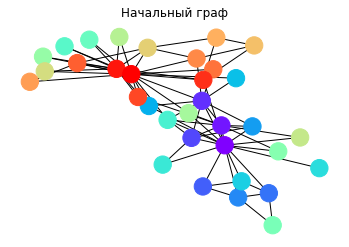

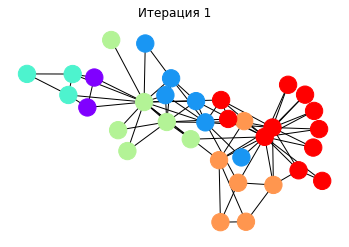

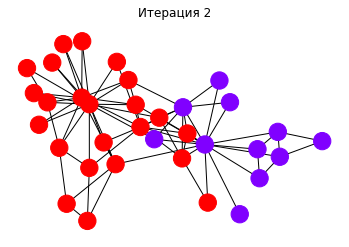

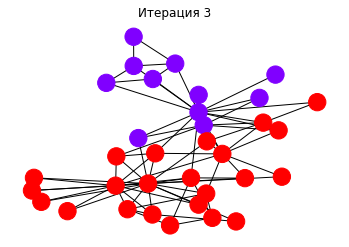

{0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1, 15: 1, 16: 0, 17: 0, 18: 1, 19: 0, 20: 1, 21: 0, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1}


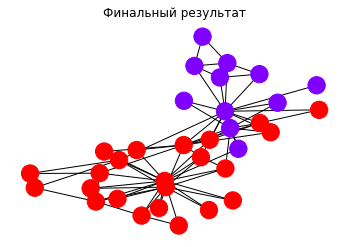

In [3]:
## Отрисовка графа и его сообществ
## Сообщество - словарь вида {узел : сообщество, к которому он принадлежит}
def draw(graph, communities,title = ''):
    rainbow = cm.rainbow(np.linspace(0, 1, max(communities.values()) + 1))
    node_color = [rainbow[communities[it]] for it in graph.nodes]
    plt.title(title)
    nx.draw(graph, node_color=node_color)
    plt.show()
    
## Преобразование сообществ из словаря в список 
def communities_dict_to_list(communities):
    ret = [[] for i in range(max(communities.values()) + 1)]
    for k, v in communities.items():
        ret[v].append(k)
    return list(filter(None, ret))

## модулярность графа, если перетащить узел в другое сообщество 
## communities - словарь
def gain_from_moving(graph, communities_, node, c):
    communities = communities_.copy()
    communities[node] = c
    return nx.community.modularity(graph, communities_dict_to_list(communities))

## 1 Фаза - максимизация модулярности
## Возвращает сообщество с лучшей модулярностью в виде списка
def modularity_optimization(graph):
    prev_communities = {i: -1 for i in range(len(graph))}
    cur_communities = {i: i for i in range(len(graph))}

    while prev_communities != cur_communities:
        prev_communities = cur_communities.copy()
        for node in graph:
            neighbor_communities = [cur_communities[it] for it in graph.neighbors(node)] ## поиск смежных сообществ
            gains = {it: gain_from_moving(graph, cur_communities, node, it) for it in neighbor_communities} ## выигрыш от перемещения узла в соседнее сообщество
            best_community = max(gains, key=gains.get) ## смежное сообщество с max выигрышем
            cur_communities[node] = best_community
        
    return communities_dict_to_list(cur_communities)

## Возвращает список вершин между сообществами c1,c2
## communnities - список
def edges_between_communities(graph, communities, c1, c2):
    ret = []
    for i in communities[c1]:
        for k in communities[c2]:
            if (i, k) in graph.edges:
                ret.append((i, k))
    return ret
 
## Фаза 2 - объединение сообществ узлов в суперузел
## cumminities - список
def community_aggregation(graph, communities):
    super_graph = nx.Graph()
    super_graph.add_nodes_from(range(len(communities)))
    for i in range(len(communities)):
        for k in range(len(communities)):
            edges = edges_between_communities(graph, communities, i, k) ## проверка связи между двумя сообществами
            if edges:
                super_graph.add_edge(i, k)
    
    return super_graph

##  Находим, к какому суперузлу принадлежит узел
## возвращеет communities - словарь
def communities_from_states(graph, states):
    communities = {i: i for i in range(len(graph))}
    for node in communities:
        for state in states:
            community = state[1].index(next(filter(lambda x: communities[node] in x, state[1])))
            communities[node] = community
    return communities
 
## реализация Лувенского алгоритма
## возвращет списко сообществ, при которыз достигается максимальная модулярность.
def louvain(graph_):
    prev_graph = nx.Graph()
    cur_graph = graph_.copy()
    
    states = []
    i = 1
    
    while prev_graph.edges != cur_graph.edges:
        prev_graph = cur_graph.copy()
        communities = modularity_optimization(cur_graph)
        super_graph = community_aggregation(cur_graph, communities)
        states.append((cur_graph.nodes, communities.copy()))
        cur_graph = super_graph.copy()
        draw(graph_, communities_from_states(graph_, states), f'Итерация {i}')
        i += 1
        
    return communities_from_states(graph, states)
        
graph = nx.karate_club_graph()
draw(graph, {i: i for i in range(len(graph))}, 'Начальный граф')
communities = louvain(graph)
print(communities)
draw(graph, communities,'Финальный результат')